In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
AIRCRAFT_NAME = [
    # USA
    'A-10',
    'B-1',
    'B-2',
    'B-52',
    'C-5',
    'C-17',
    'C-130',
    'CV-22',
    'F-15',
    'F-16',
    'FA-18',
    'F-22',
    'F-35',
    'AH-1',
    'AH-64',
    'CH-46',
    'CH-47',
    'CH-53',
    'UH-60',
    # Europe
    'EF2000',
    'Rafale',
    'JAS-39',
    'AV-8',
    # Russia
    'MIG-29',
    'MIG-31',
    'MIG-35',
    'Su-30',
    'Su-34',
    'Su-57',
    'Tu-160',
    'Mi-8',
    'Mi-24',
    'Mi-28',
    'Ka-52',
    # CHINA
    'J-15',
    'J-20',
    'H-6',
    'Y-20',
    'WZ-10',
    # Unidentified
    'UNIDENTIFIED'
]

# 1번 코드: 육지/해양/공중 분류 모델
class VehicleCNN(nn.Module):
      
    def __init__(self, num_classes=3):  # num_classes는 분류하고자 하는 클래스가 육, 해, 공 3종류이므로 3으로 설정
        super(VehicleCNN, self).__init__()
        # 첫 번째 합성곱 레이어: 입력 채널 1, 출력 채널 64, 커널 크기 3, 스트라이드 1, 패딩 'same'
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding='same')   # 입력 채널 1 (grayscale 이미지) -> 최후수단 padding='same'
        # 최대 풀링 레이어: 커널 크기 2, 스트라이드 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 첫 번째 드롭아웃 레이어: 드롭아웃 비율 0.25
        self.dropout1 = nn.Dropout(0.25)
        
        # 두 번째 합성곱 레이어: 입력 채널 64, 출력 채널 128, 커널 크기 3, 스트라이드 1, 패딩 'same'
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same') # 위에서 out_channels 64-> 32-> 16 -> 8 ->10 -> 64 ->128로 바꿈 
        # 두 번째 드롭아웃 레이어: 드롭아웃 비율 0.25
        self.dropout2 = nn.Dropout(0.25)

        # 세 번째 합성곱 레이어: 입력 채널 64, 출력 채널 128, 커널 크기 3, 스트라이드 1, 패딩 'same'
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same') # 위에서 out_channels 64-> 32-> 16 -> 8 ->10 -> 64 ->128로 바꿈 
        # 세 번째 드롭아웃 레이어: 드롭아웃 비율 0.25
        self.dropout3 = nn.Dropout(0.25)
        
        # 첫 번째 완전 연결 레이어: 입력 특성 128*12*12, 출력 특성 50
        self.fc1 = nn.Linear(128 * 6 * 6, 50)                       # 120 -> 60 -> 30 -> 50
        # 세 번째 드롭아웃 레이어: 드롭아웃 비율 0.5
        self.dropout4 = nn.Dropout(0.5)
        
        # 두 번째 완전 연결 레이어: 입력 특성 50, 출력 특성 num_classes
        self.fc2 = nn.Linear(50, num_classes)
        
    def forward(self, x):
        # 첫 번째 합성곱 적용
        x = self.conv1(x)
        # 활성화 함수 ReLU 적용
        x = F.relu(x)
        # 최대 풀링 적용
        x = self.pool(x)
        # 첫 번째 드롭아웃 적용
        x = self.dropout1(x)

        # 두 번째 합성곱 적용
        x = self.conv2(x)
        # 활성화 함수 ReLU 적용
        x = F.relu(x)
        # 최대 풀링 적용
        x = self.pool(x)
        # 두 번째 드롭아웃 적용
        x = self.dropout2(x)

        # 세 번째 합성곱 적용
        x = self.conv3(x)
        # 활성화 함수 ReLU 적용
        x = F.relu(x)
        # 최대 풀링 적용
        x = self.pool(x)
        # 세 번째 드롭아웃 적용
        x = self.dropout3(x)

        # 특성 벡터로 변환 (평탄화)
        x = x.view(x.size(0), -1)

        # 첫 번째 완전 연결 레이어 적용
        x = self.fc1(x)
        # 활성화 함수 ReLU 적용
        x = F.relu(x)
        # 세 번째 드롭아웃 적용
        x = self.dropout4(x)

        # 두 번째 완전 연결 레이어 적용
        x = self.fc2(x)

        return x

def load_model_1(model_path):
    model = VehicleCNN(num_classes=3)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# 2번 코드: 차량 브랜드 분류 모델
vgg = models.vgg16(pretrained=True)

# VGG 첫 번째 컨볼루션 레이어의 입력 채널 수 수정
vgg.features[0] = nn.Conv2d(1, 64, kernel_size=5, padding=1)

vgg = models.vgg16(pretrained=True)
vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)

for param in vgg.features.parameters():
    param.requires_grad = False

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])
img_root = 'data'
dataset = ImageFolder(root=img_root, transform=transform)

num_features = vgg.classifier[0].in_features
vgg.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(dataset.classes))
)

def load_model_2(model_path):
    model = vgg.to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# 3번 코드: 군용기 분류 모델
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 128, 3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 128, 3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, 3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            nn.Linear(128*12*12, num_classes)
        )
        
    def forward(self, x):
        return self.layers(x)

def load_model_3(model_path):
    model = CNN(num_classes=len(AIRCRAFT_NAME))
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])

# 모델 로드
model_1 = load_model_1('best_model1.pth')
model_2 = load_model_2('best_model2.pth')
model_3 = load_model_3('best_model3.pth')

# 이미지 예측
def predict_image(img_path):
    image = Image.open(img_path)
    image = transform(image).unsqueeze(0)

    # 1번 코드: 육지/해양/공중 분류
    with torch.no_grad():
        output_1 = model_1(image)
        prediction_1 = output_1.argmax(dim=1).item()

    # vgg = models.vgg16(pretrained=True)
    # vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)


    if prediction_1 == 0:  # 육지
        # 2번 코드: 차량 브랜드 분류
        with torch.no_grad():
            output_2 = model_2(image)
            prediction_2 = output_2.argmax(dim=1).item()
        print(f"예측 브랜드: {brandList[prediction_2]}")
    elif prediction_1 == 2:  # 공중
        # 3번 코드: 군용기 분류
        with torch.no_grad():
            output_3 = model_3(image)
            prediction_3 = output_3.argmax(dim=1).item()
        print(f"예측 군용기: {AIRCRAFT_NAME[prediction_3]}")
    else:  # 해양
        print("해양 운송수단입니다.")

# 이미지 경로 설정
img_path = 'imagetest.png'

# 예측 실행
predict_image(img_path)

/Users/sml/anaconda3/envs/Torch_PY38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sml/anaconda3/envs/Torch_PY38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 4, 50, 50] to have 1 channels, but got 4 channels instead

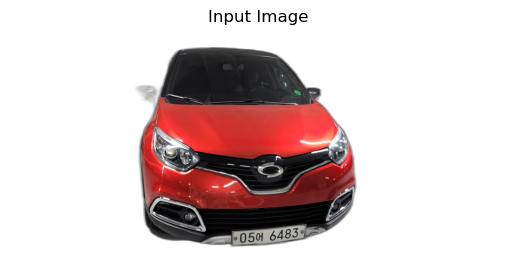

Model 1 :
예측: 해양 운송수단입니다.
해양 운송수단입니다.


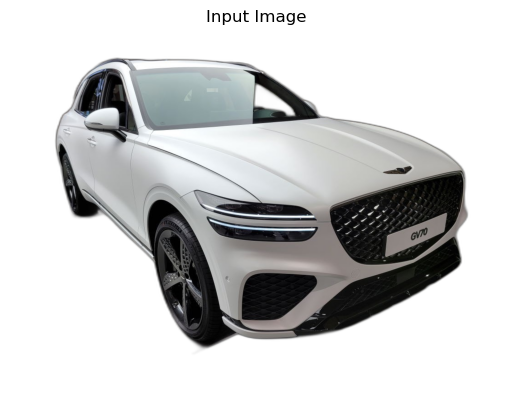

Model 1 :
예측: 해양 운송수단입니다.
해양 운송수단입니다.


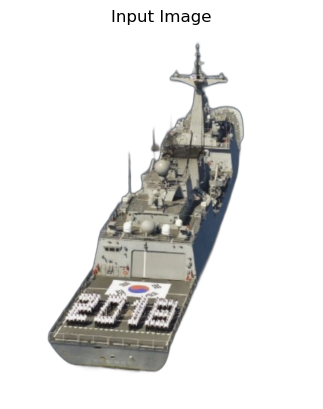

Model 1 :
예측: 해양 운송수단입니다.
해양 운송수단입니다.


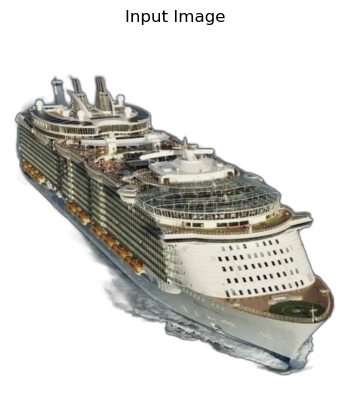

Model 1 :
예측: 해양 운송수단입니다.
해양 운송수단입니다.


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt



DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
AIRCRAFT_NAME = [
    # USA
    'A-10',
    'B-1',
    'B-2',
    'B-52',
    'C-5',
    'C-17',
    'C-130',
    'CV-22',
    'F-15',
    'F-16',
    'FA-18',
    'F-22',
    'F-35',
    'AH-1',
    'AH-64',
    'CH-46',
    'CH-47',
    'CH-53',
    'UH-60',
    # Europe
    'EF2000',
    'Rafale',
    'JAS-39',
    'AV-8',
    # Russia
    'MIG-29',
    'MIG-31',
    'MIG-35',
    'Su-30',
    'Su-34',
    'Su-57',
    'Tu-160',
    'Mi-8',
    'Mi-24',
    'Mi-28',
    'Ka-52',
    # CHINA
    'J-15',
    'J-20',
    'H-6',
    'Y-20',
    'WZ-10',
    # Unidentified
    'UNIDENTIFIED'
]

# 1번 코드: 육지/해양/공중 분류 모델
class VehicleCNN(nn.Module):
      
    def __init__(self, num_classes=3):  # num_classes는 분류하고자 하는 클래스가 육, 해, 공 3종류이므로 3으로 설정
        super(VehicleCNN, self).__init__()
        # 첫 번째 합성곱 레이어: 입력 채널 1, 출력 채널 64, 커널 크기 3, 스트라이드 1, 패딩 'same'
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding='same')   # 입력 채널 1 (grayscale 이미지) -> 최후수단 padding='same'
        # 최대 풀링 레이어: 커널 크기 2, 스트라이드 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 첫 번째 드롭아웃 레이어: 드롭아웃 비율 0.25
        self.dropout1 = nn.Dropout(0.25)
        
        # 두 번째 합성곱 레이어: 입력 채널 64, 출력 채널 128, 커널 크기 3, 스트라이드 1, 패딩 'same'
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same') # 위에서 out_channels 64-> 32-> 16 -> 8 ->10 -> 64 ->128로 바꿈 
        # 두 번째 드롭아웃 레이어: 드롭아웃 비율 0.25
        self.dropout2 = nn.Dropout(0.25)

        # 세 번째 합성곱 레이어: 입력 채널 64, 출력 채널 128, 커널 크기 3, 스트라이드 1, 패딩 'same'
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same') # 위에서 out_channels 64-> 32-> 16 -> 8 ->10 -> 64 ->128로 바꿈 
        # 세 번째 드롭아웃 레이어: 드롭아웃 비율 0.25
        self.dropout3 = nn.Dropout(0.25)
        
        # 첫 번째 완전 연결 레이어: 입력 특성 128*12*12, 출력 특성 50
        self.fc1 = nn.Linear(128 * 6 * 6, 50)                       # 120 -> 60 -> 30 -> 50
        # 세 번째 드롭아웃 레이어: 드롭아웃 비율 0.5
        self.dropout4 = nn.Dropout(0.5)
        
        # 두 번째 완전 연결 레이어: 입력 특성 50, 출력 특성 num_classes
        self.fc2 = nn.Linear(50, num_classes)
        
    def forward(self, x):
        # 첫 번째 합성곱 적용
        x = self.conv1(x)
        # 활성화 함수 ReLU 적용
        x = F.relu(x)
        # 최대 풀링 적용
        x = self.pool(x)
        # 첫 번째 드롭아웃 적용
        x = self.dropout1(x)

        # 두 번째 합성곱 적용
        x = self.conv2(x)
        # 활성화 함수 ReLU 적용
        x = F.relu(x)
        # 최대 풀링 적용
        x = self.pool(x)
        # 두 번째 드롭아웃 적용
        x = self.dropout2(x)

        # 세 번째 합성곱 적용
        x = self.conv3(x)
        # 활성화 함수 ReLU 적용
        x = F.relu(x)
        # 최대 풀링 적용
        x = self.pool(x)
        # 세 번째 드롭아웃 적용
        x = self.dropout3(x)

        # 특성 벡터로 변환 (평탄화)
        x = x.view(x.size(0), -1)

        # 첫 번째 완전 연결 레이어 적용
        x = self.fc1(x)
        # 활성화 함수 ReLU 적용
        x = F.relu(x)
        # 세 번째 드롭아웃 적용
        x = self.dropout4(x)

        # 두 번째 완전 연결 레이어 적용
        x = self.fc2(x)

        return x

def load_model_1(model_path):
    model = VehicleCNN(num_classes=3)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# 2번 코드: 차량 브랜드 분류 모델
vgg = models.vgg16(pretrained=True)

# VGG 첫 번째 컨볼루션 레이어의 입력 채널 수 수정
vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)

for param in vgg.features.parameters():
    param.requires_grad = False

num_features = vgg.classifier[0].in_features
vgg.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(dataset.classes))
)

def load_model_2(model_path):
    model = vgg.to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])
# 3번 코드: 군용기 분류 모델
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 128, 3, padding='same'),  # 입력 채널 수를 3으로 변경
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 128, 3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, 3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            nn.Linear(128*12*12, num_classes)
        )
        
    def forward(self, x):
        return self.layers(x)

def load_model_3(model_path):
    model = CNN(num_classes=len(AIRCRAFT_NAME))
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# 이미지 전처리
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])

# 모델 로드
model_1 = load_model_1('best_model1.pth')
model_2 = load_model_2('best_model2.pth')
model_3 = load_model_3('best_model3.pth')

# 이미지 예측
def predict_image(img_path):
    # 이미지 로드 및 출력
    image = Image.open(img_path)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')
    plt.show()
    
    # 이미지 전처리
    transformed_image = transform(image).unsqueeze(0)

    # 1번 코드: 육지/해양/공중 분류
    with torch.no_grad():
        output_1 = model_1(transformed_image)
        prediction_1 = output_1.argmax(dim=1).item()
        print(f"Model 1 :")
        print(f"예측: {'육지 운송수단입니다.' if prediction_1 == 0 else '공중 운송수단입니다.' if prediction_1 == 2 else '해양 운송수단입니다.'}")

    if prediction_1 == 0:  # 육지
        # 2번 코드: 차량 브랜드 분류
        with torch.no_grad():
            output_2 = model_2(transformed_image.to(DEVICE))
            prediction_2 = output_2.argmax(dim=1).item()
            print(f"Model 2 Output: {output_2}")
            print(f"예측 : 브랜드는 {dataset.classes[prediction_2]}입니다.")  # dataset.classes needs to be defined or replaced with actual brand list
    elif prediction_1 == 2:  # 공중
        # 3번 코드: 군용기 분류
        with torch.no_grad():
            output_3 = model_3(transformed_image)
            prediction_3 = output_3.argmax(dim=1).item()
            print(f"Model 3 Output: {output_3}")
            print(f"예측 : 군용기 {AIRCRAFT_NAME[prediction_3]}입니다.")
    else:  # 해양
        print("해양 운송수단입니다.")

# 이미지 경로 설정
img_path = 'imagetest.png'
image = Image.open(img_path)

predict_image(img_path)

img_path = 'imagetest2.png'
image = Image.open(img_path)

predict_image(img_path)

img_path = 'imagetest3.png'
image = Image.open(img_path)

predict_image(img_path)

img_path = 'imagetest4.png'
image = Image.open(img_path)

predict_image(img_path)

img_path = 'imagetest5.png'
image = Image.open(img_path)

predict_image(img_path)

img_path = 'imagetest6.png'
image = Image.open(img_path)

predict_image(img_path)